# 样例数据词袋模型

### 英文（twitter)

In [53]:
import re
import nltk
import jieba
import string
import pandas as pd
from nltk import pos_tag
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# 导入数据
text_twi = pd.read_csv(r'D:\研一下 作业\文本分析\词袋模型\text_analysis_twitter.csv')
text_twi = text_twi.drop(['Unnamed: 0'], axis=1)

In [4]:
text_twi.head()

,id,screen_name,time,link,text,source
0,881004944714866688,KamalaHarris,2017-07-01T00:22:01-04:00,https://www.twitter.com/KamalaHarris/statuses/...,Republicans are trying to steal health care fr...,Sprout Social
1,881002538341986304,MarcVeasey,2017-07-01T00:12:28-04:00,https://www.twitter.com/kylegriffin1/statuses/...,RT @kylegriffin1 Rep. Mark Veasay has introduc...,Twitter for Android
2,881001393284419584,RepPaulTonko,2017-07-01T00:07:55-04:00,https://www.twitter.com/RepPaulTonko/statuses/...,A top U.S. science office went dark tonight. N...,Twitter for iPhone
3,881000301007958016,clairecmc,2017-07-01T00:03:34-04:00,https://www.twitter.com/clairecmc/statuses/881...,So the fundraising quarter ends in an hour in ...,Twitter for iPad
4,881015727540637696,tedcruz,2017-07-01T01:04:52-04:00,https://www.twitter.com/larry_kudlow/statuses/...,RT @larry_kudlow Important story @SenTedCruz @...,Twitter for iPhone


In [38]:
# 具体展示语料
text_list = list(text_twi['text'])
text_list[:5]

['Republicans are trying to steal health care from 22 million people in order to help the wealthiest 0.4%.',
 "RT @kylegriffin1 Rep. Mark Veasay has introduced a bill to ensure no taxpayer funds will be used to support Trump's Election Commission. http://pbs.twimg.com/media/DDm3PgaXcAAFBIo.jpg",
 'A top U.S. science office went dark tonight. Not good. #sciencematters https://twitter.com/elleabella1112/status/880870684485984256 QT @elleabella1112 science division out. mic drop. http://pbs.twimg.com/media/DDl7NT9XoAEeJxb.jpg',
 'So the fundraising quarter ends in an hour in MO. I would really appreciate a $5 contribution. Thank you so much. http://clairemccaskill.com/donate',
 'RT @larry_kudlow Important story @SenTedCruz @NRO. http://www.nationalreview.com/article/449134/ted-cruz-conservative-health-care-proposal?utm_campaign=trueanthem&utm_content=595717ee04d3010ccd0c715e&utm_medium=social&utm_source=twitter']

In [7]:
# 下载
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
## Data Cleaning and Text Processing.
def preprocess_text(text):
    # 小写
    text = text.lower()
    
    # 移除URL
    text = re.sub(r'http\S+', '',text)
    
    # 分词
    tokens = word_tokenize(text)
    
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    
    # 去除标点符号和数字 和其他一些字符
    filtered_tokens = [word for word in filtered_tokens if word.isalpha() and word !='rt']
    #filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]
    
    # 词性标注与筛选
    #pos_tags = pos_tag(filtered_tokens)
    #selected_tokens = [word  for word, pos in pos_tags if pos.startswith('N') or pos.startswith('J') or pos.startswith('V')]
    
    # 词性还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
  
    # 返回预处理后的文本
    return ' '.join(lemmatized_tokens)


# 定义函数将词性标签映射到 WordNet 词性标签
# def get_wordnet_pos(treebank_tag):
#     if treebank_tag.startswith('J'):
#         return 'a'  # 形容词
#     elif treebank_tag.startswith('V'):
#         return 'v'  # 动词
#     elif treebank_tag.startswith('N'):
#         return 'n'  # 名词
#     else:
#         return None  # 默认为名词

text_twi['text_clean'] = text_twi['text'].apply(preprocess_text)    

In [16]:
text_clean = list(text_twi['text_clean'])
text_clean[:10]

['republican trying steal health care million people order help wealthiest',
 'mark veasay introduced bill ensure taxpayer fund used support trump election commission',
 'top science office went dark tonight good sciencematters qt science division mic drop',
 'fundraising quarter end hour mo would really appreciate contribution thank much',
 'important story sentedcruz nro',
 'threat already higher resist',
 'happy birthday senjoniernst',
 'read reploucorrea article one california finest officer achieving american dream heretostay',
 'airandspace year ago today official ribbon cutting museum dc triggered spacecraft orbiting mar',
 'great job daylen littleleague baseball esva qt eastern shore little league player invited national mlb event']

In [21]:
# 计算词频

# 初始化CountVectorizer
vectorizer = CountVectorizer()

# 将文本数据转换为词袋特征矩阵
X = vectorizer.fit_transform(text_clean)

# 获得词汇表
feature_words = vectorizer.get_feature_names_out()

word_freq = dict(zip(feature_words, X.sum(axis=0).A1))

sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

[('amp', 65502),
 ('qt', 35691),
 ('tax', 32961),
 ('today', 24415),
 ('american', 21801),
 ('bill', 21156),
 ('trump', 19421),
 ('family', 18268),
 ('need', 15323),
 ('health', 14042),
 ('house', 13537),
 ('great', 13409),
 ('people', 13404),
 ('help', 13143),
 ('must', 12525),
 ('act', 12330),
 ('time', 11775),
 ('care', 11704),
 ('thank', 11515),
 ('work', 11236),
 ('new', 10994),
 ('senate', 10738),
 ('congress', 10587),
 ('would', 10556),
 ('day', 10506),
 ('job', 10469),
 ('plan', 10422),
 ('year', 10403),
 ('support', 10170),
 ('cut', 10119),
 ('gop', 10052),
 ('make', 9958),
 ('vote', 9718),
 ('get', 9622),
 ('state', 9289),
 ('one', 9284),
 ('republican', 8796),
 ('realdonaldtrump', 8591),
 ('community', 8497),
 ('right', 8127),
 ('taxreform', 8020),
 ('president', 8012),
 ('reform', 7978),
 ('potus', 7816),
 ('million', 7682),
 ('see', 7654),
 ('thanks', 7604),
 ('country', 7600),
 ('working', 7305),
 ('live', 7185),
 ('woman', 7130),
 ('proud', 7123),
 ('watch', 7025),
 ('am

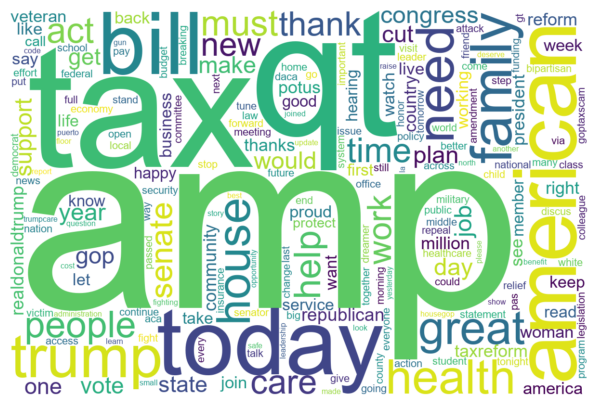

In [26]:
# 词云图
wordcloud = WordCloud(width=1200, height=800, background_color='white', font_path='arial.ttf').generate_from_frequencies(word_freq)

# 可视化
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
#plt.savefig('wordcloud_twi.png', dpi=100)

### 中文（微博）

In [46]:
# 导入数据
text_weibo = pd.read_csv(r'D:\研一下 作业\文本分析\词袋模型\text_analysis_weibo.csv')
text_weibo = text_weibo.drop(['Unnamed: 0'],axis = 1)
text_weibo.head()

,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域
0,#高校通报教师图书馆打电话声音过大出言不逊#公道自在人心，谣言自在人心 ​​,0,0,0,a2331b38901d62d2d9a20529177ef3b3,0,22,湖北
1,转发C,0,0,0,d6dc4470f51fce93cc0cbad8abf55a75,0,33,广西
2,【#刘雨昕运动者联濛#河山覆冰雪，健儿迎冬奥[金牌]全能唱跳不设限，运动联濛开新年🇨🇳 期待...,0,0,0,372bc4782eb442b88035f920a7c1a68e,6,85,广东
3,丁程鑫//@丁程鑫后援会官博:#丁程鑫[超话]# ✨#丁程鑫 二十成金筑梦鑫世界# 大年初一...,0,0,0,6fe0d482bd3e78a3483e2a1d57f14ef2,75,1012,广东
4,诶，你们真不要脸诶。。。没资格宣传奥运。。。抵制抵制！,0,0,0,872380d71d6ee9130e8b49d331f2baa9,0,10,广东


In [48]:
# 分析语料
text_w= list(text_weibo['标题/微博内容'])
text_w[:5]

['#高校通报教师图书馆打电话声音过大出言不逊#公道自在人心，谣言自在人心 \u200b\u200b',
 '转发C',
 '【#刘雨昕运动者联濛#河山覆冰雪，健儿迎冬奥[金牌]全能唱跳不设限，运动联濛开新年🇨🇳 期待全能音乐人@刘雨昕 与#运动者联濛#一起，为冬奥赛事助力加油！】',
 '丁程鑫//@丁程鑫后援会官博:#丁程鑫[超话]# ✨#丁程鑫 二十成金筑梦鑫世界# 大年初一锁定@北京卫视 和门面主舞@时代少年团-丁程鑫 一起过大年，拥抱冰雪，致敬冬奥！',
 '诶，你们真不要脸诶。。。没资格宣传奥运。。。抵制抵制！']

In [60]:
# 下载
stopwords = open(r'D:\研一下 作业\文本分析\词袋模型\stopwords.txt', encoding = 'utf-8').read()

In [ ]:
# 数据预处理
def data_preprocess_chi(text):
    # 剔除符号与数字
    nonums_text = re.sub('[^\u4e00-\u9fa5]+', '', str(text))
        
    # 分词
    words = jieba.cut(nonums_text)
    
    # 去除停用词
    words = [w for w in words if w not in list(stopwords) and w!='\u200b' and w!='转发']
    
    return ' '.join(words)

text_weibo['clean_text'] = text_weibo['标题/微博内容'].apply(data_preprocess_chi)

In [ ]:
# 展示预处理成果
text = list(text_weibo['clean_text'])
text

In [ ]:
# 计算词频

# 初始化CountVectorizer
vectorizer = CountVectorizer()

# 将文本数据转换为词袋特征矩阵
X = vectorizer.fit_transform(text)

# 获取词汇表
feature_words = vectorizer.get_feature_names_out()

# 计算词频统计
word_freq = dict(zip(feature_words, X.sum(axis=0).A1))

# 排序
sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# 可视化词云图
wordcloud = WordCloud(
    font_path='simhei.ttf',  
    background_color='white',  
    width=1200,
    height=800,
    max_words=200,  
    max_font_size=100  
).generate_from_frequencies(word_freq)

# 显示词云图
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 使用自己数据跑一下

In [ ]:
# 导入数据
text_wj = pd.read_csv(r'D:\研一下 作业\文本分析\词袋模型\D:\研一下 作业\文本分析\词袋模型\CMFA(1).xlsx')
text_wj = text_twi.drop(['Unnamed: 0'], axis=1)

In [ ]:
text_wj.head()

In [ ]:
## Data Cleaning and Text Processing.
def preprocess_text(text):
    # 小写
    text = text.lower()
    
    # 分词
    tokens = word_tokenize(text)
    
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # 去除标点符号和数字
    filtered_tokens = [word for word in filtered_tokens if word.isalpha()]
    #filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]
    
    # 词性标注与筛选
    pos_tags = pos_tag(filtered_tokens)
    #selected_tokens = [word  for word, pos in pos_tags if pos.startswith('N') or pos.startswith('J') or pos.startswith('V')]
    
    # 词性还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags if pos.startswith('N') or pos.startswith('J') or pos.startswith('V')]
  
    # 返回预处理后的文本
    return ' '.join(lemmatized_tokens)


# 定义函数将词性标签映射到 WordNet 词性标签
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # 形容词
    elif treebank_tag.startswith('V'):
        return 'v'  # 动词
    elif treebank_tag.startswith('N'):
        return 'n'  # 名词
    else:
        return None  # 默认为名词

df['answer_processed'] = df['answer'].apply(preprocess_text)

In [ ]:
# 展示预处理结果
text_wj_list = list(df['answer_processed'])
text_wj_list[:10]

In [ ]:
# 计算词频
# 计算词频

# 初始化CountVectorizer
vectorizer = CountVectorizer()

# 将文本数据转换为词袋特征矩阵
X = vectorizer.fit_transform(text_wj_list)

# 获得词汇表
feature_words = vectorizer.get_feature_names_out()

word_freq = dict(zip(feature_words, X.sum(axis=0).A1))

sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# 可视化—词云图
wordcloud = WordCloud(
    font_path='simhei.ttf',  
    background_color='white',  
    width=1200,
    height=800,
    max_words=200,  
    max_font_size=100  
).generate_from_frequencies(word_freq)

# 显示词云图
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()